# Let's preprocess the data

In [111]:
import pandas as pd
import seaborn as sns
import glob
import os 
import re

sns.set_theme()

## Pre visualisation

In [112]:
list_paths = glob.glob('./data/*')
list_paths.sort()
print(list_paths)


df_test = pd.read_csv(list_paths[0], compression='gzip')

# Preview the data
df_test.head()

['./data/20211201.csv.gz', './data/20211202.csv.gz', './data/20211203.csv.gz', './data/20211206.csv.gz', './data/20211207.csv.gz', './data/20211208.csv.gz', './data/20211209.csv.gz', './data/20211210.csv.gz', './data/20211213.csv.gz', './data/20211214.csv.gz', './data/20211215.csv.gz', './data/20211216.csv.gz', './data/20211217.csv.gz', './data/20211220.csv.gz', './data/20211221.csv.gz', './data/20211222.csv.gz', './data/20211223.csv.gz', './data/20211227.csv.gz', './data/20211228.csv.gz', './data/20211229.csv.gz', './data/20211230.csv.gz', './data/20211231.csv.gz']


,DATE,SYMBOL,TIME,ALL_EX,MID_OPEN,SUM_DELTA
0,20211201,A,09:30:00,DNYBTJVPCZUKXHA,152.190,-8.401819
1,20211201,A,09:40:00,PBTJVDZUYKNHCXM,150.490,0.473357
2,20211201,A,09:50:00,KDPBTJVNZUCXYH,151.475,-10.867709
3,20211201,A,10:00:00,DABTJNKYVPZUXCH,150.510,-0.125414
4,20211201,A,10:10:00,DVJTPNKUZYACBXHM,151.960,-1.274648


## Selecting the appropriate tickers and building the data frame

In [126]:
url_dict = {
    'sp500': ("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies", 0, "Symbol"),
    'russell1000': ("https://en.wikipedia.org/wiki/Russell_1000_Index", 3, 'Symbol'),
    'ftse100': ("https://en.wikipedia.org/wiki/FTSE_100_Index", 4, "Ticker"),
}

In [127]:
list_tickers = []

for key, (url, table_index, ticker_column) in url_dict.items():
    if key in ['sp500']: #'russell1000', 'ftse100']:
        try:
            df = pd.read_html(url)[table_index]
            tickers = df[ticker_column].tolist()
            list_tickers += tickers
            print(f"{key}: {len(tickers)} tickers found.")
        except Exception as e:
            print(f"Error processing {key}: {e}")

sp500: 503 tickers found.


In [128]:
df_list = []

for path in list_paths:
    print(f"Processing file: {path.split('/')[-1]}")
    df = pd.read_csv(path, compression='gzip')
    df['SYMBOL'] = df['SYMBOL'].str.upper()
    df = df[df['SYMBOL'].isin(list_tickers)]
    df_list.append(df)

Processing file: 20211201.csv.gz
Processing file: 20211202.csv.gz
Processing file: 20211203.csv.gz
Processing file: 20211206.csv.gz
Processing file: 20211207.csv.gz
Processing file: 20211208.csv.gz
Processing file: 20211209.csv.gz
Processing file: 20211210.csv.gz
Processing file: 20211213.csv.gz
Processing file: 20211214.csv.gz
Processing file: 20211215.csv.gz
Processing file: 20211216.csv.gz
Processing file: 20211217.csv.gz
Processing file: 20211220.csv.gz
Processing file: 20211221.csv.gz
Processing file: 20211222.csv.gz
Processing file: 20211223.csv.gz
Processing file: 20211227.csv.gz
Processing file: 20211228.csv.gz
Processing file: 20211229.csv.gz
Processing file: 20211230.csv.gz
Processing file: 20211231.csv.gz


In [154]:
df = pd.concat(df_list, ignore_index=True)

df = df.drop(columns=['ALL_EX', 'SUM_DELTA'])

df['DATE_FORMATTED'] = df['DATE'].apply(lambda x: str(x)[:4] + '-' + str(x)[4:6] + '-' + str(x)[6:8])
df['DATE_FORMATTED'] = pd.to_datetime(df['DATE_FORMATTED'], format='%Y-%m-%d')
df['DATETIME'] = pd.to_datetime(df['DATE_FORMATTED'].astype(str) + ' ' + df['TIME'])
# df = df.drop(columns=['DATE', 'TIME'])

df = df.sort_values(by=['SYMBOL', 'DATETIME'])

df.head()


,DATE,SYMBOL,TIME,MID_OPEN,DATE_FORMATTED,DATETIME
0,20211201,A,09:30:00,152.190,2021-12-01,2021-12-01 09:30:00
1,20211201,A,09:40:00,150.490,2021-12-01,2021-12-01 09:40:00
2,20211201,A,09:50:00,151.475,2021-12-01,2021-12-01 09:50:00
3,20211201,A,10:00:00,150.510,2021-12-01,2021-12-01 10:00:00
4,20211201,A,10:10:00,151.960,2021-12-01,2021-12-01 10:10:00


## Building the features

## Plotting / Debugging

<Axes: xlabel='DATETIME'>

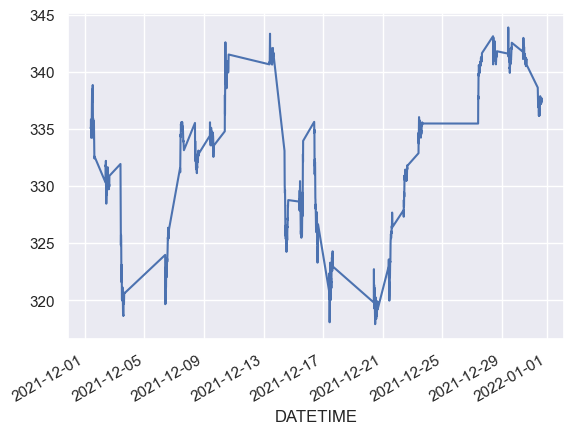

In [148]:
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)

df[df['SYMBOL'] == 'MSFT']['MID_OPEN'].plot()